In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from nltk.stem.porter import *
import re
from sklearn.feature_extraction import text

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# hide warnings
import warnings 
warnings.filterwarnings("ignore")

In [3]:
training_data = pd.read_csv('Data/train.csv', index_col = [0])

In [4]:
test_data = pd.read_csv('Data/test.csv', index_col = [0])

In [5]:
training_data.product_description = training_data.product_description.fillna('')
test_data.product_description = test_data.product_description.fillna('')

Preprocessing

In [6]:
# stop word removal
stemmer = PorterStemmer()
sw=[]
ML_STOP_WORDS = ['http','www','img','border','color','style','padding','table','font','inch','width','height']
ML_STOP_WORDS += list(text.ENGLISH_STOP_WORDS)
for stw in ML_STOP_WORDS:
    sw.append("z"+str(stw))
ML_STOP_WORDS += sw
for i in range(len(ML_STOP_WORDS)):
    ML_STOP_WORDS[i]=stemmer.stem(ML_STOP_WORDS[i])

In [7]:
# declarations
def ML_TEXT_CLEAN(f2,f3):
    if len(f2)<3:
        f2="feature2null"
    if len(f3)<3:
        f3="feature3null"
    tx = BeautifulSoup(f3)
    tx1 = [x.extract() for x in tx.findAll('script')]
    tx = tx.get_text(" ").strip()
    #s = (" ").join(["z"+ str(z) for z in f2.split(" ")]) + " " + tx
    s = (" ").join([str(z) for z in f2.split(" ")]) + " " + tx
    s = re.sub("[^a-zA-Z0-9]"," ", s)
    s = re.sub("[0-9]{1,3}px"," ", s)
    s = re.sub(" [0-9]{1,6} |000"," ", s)
    s = (" ").join([stemmer.stem(z) for z in s.split(" ") if len(z)>2])
    s = s.lower()
    return s

In [8]:
# Cleaning training data
s_data = []
for i in range(len(training_data.id)):
    s = ML_TEXT_CLEAN(training_data.product_title[i], training_data.product_description[i])
    s_data.append((training_data["query"][i], s, str(training_data["median_relevance"][i])))

In [9]:
# Cleaning test data
t_data = []
for i in range(len(test_data.id)):
    s = ML_TEXT_CLEAN(test_data.product_title[i], test_data.product_description[i])
    t_data.append((test_data["query"][i], s, str(test_data["median_relevance"][i])))

In [10]:
training_df = pd.DataFrame(s_data)
test_df = pd.DataFrame(t_data)



---



**Random Forest**

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [12]:
#dimension reduction
tsvd = TruncatedSVD(n_components=200, algorithm='randomized', n_iter=5, random_state=None, tol=0.0)

In [13]:
scl = StandardScaler()
tfidf = TfidfVectorizer(max_features=2500, min_df=0.0, max_df=0.4, stop_words=ML_STOP_WORDS,
                        ngram_range=(1,3), use_idf=True, smooth_idf=True, sublinear_tf=True,
                        analyzer='word', lowercase=False)

In [14]:
clf = RandomForestClassifier(max_depth = 4, min_samples_leaf = 10)

In [15]:
parameters = { 'class__n_estimators': (10,50,100)}
pipe = Pipeline([('tfidf',tfidf),
                 ('tsvd',tsvd),
                 ('scl',scl),
                 ('class',clf)])

In [16]:
training_df_fea = training_df.loc[:, training_df.columns != 2]
training_df_fea.head()

,0,1
0,zippo hand warmer,zippo black polish hand warmer with fill cup p...
1,wall mirrors,cooper classic benedetta wall mirror diam the ...
2,rachel ray cookware,rachael ray porcelain green piec cookwar set t...
3,flea and tick control for dogs,hartz ultraguard plu flea and tick home fogger...
4,batman,comic arkham asylum batman seri the joker citi...


In [17]:
training_fea = np.array(training_df_fea)
training_fea.shape

(7618, 2)

In [18]:
training_fea = training_df_fea.apply(lambda x:'%s %s' % (x[0],x[1]),axis=1)
training_fea.shape

(7618,)

In [19]:
y = np.array(training_data["median_relevance"].values)
y.shape

(7618,)

In [20]:
pipe.fit(training_fea, y)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(lowercase=False, max_df=0.4, max_features=2500,
                                 min_df=0.0, ngram_range=(1, 3),
                                 stop_words=['http', 'www', 'img', 'border',
                                             'color', 'style', 'pad', 'tabl',
                                             'font', 'inch', 'width', 'height',
                                             'afterward', 'herein', 'also',
                                             'name', 'for', 'by', 'beforehand',
                                             'someth', 'cri', 'two', 'system',
                                             'whereaft', 'hasnt', 'they',
                                             'ourselv', 'seem', 'everyth', 'eg', ...],
                                 sublinear_tf=True)),
                ('tsvd', TruncatedSVD(n_components=200)),
                ('scl', StandardScaler()),
                ('class',
                 RandomForestClassifier(max_depth=4, min_samples_leaf=10))])

In [21]:
grid_search = GridSearchCV(pipe, parameters)
grid_search.fit(training_fea, y)

GridSearchCV(estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(lowercase=False,
                                                        max_df=0.4,
                                                        max_features=2500,
                                                        min_df=0.0,
                                                        ngram_range=(1, 3),
                                                        stop_words=['http',
                                                                    'www',
                                                                    'img',
                                                                    'border',
                                                                    'color',
                                                                    'style',
                                                                    'pad',
                                                                    'tabl',
                                                                    'font',
                                                                    'inch',
                                                                    'width',
                                                                    'height',
                                                                    'afterward',
                                                                    'herein',
                                                                    'also',
                                                                    'name',
                                                                    'for', 'by',
                                                                    'beforehand',
                                                                    'someth',
                                                                    'cri',
                                                                    'two',
                                                                    'system',
                                                                    'whereaft',
                                                                    'hasnt',
                                                                    'they',
                                                                    'ourselv',
                                                                    'seem',
                                                                    'everyth',
                                                                    'eg', ...],
                                                        sublinear_tf=True)),
                                       ('tsvd', TruncatedSVD(n_components=200)),
                                       ('scl', StandardScaler()),
                                       ('class',
                                        RandomForestClassifier(max_depth=4,
                                                               min_samples_leaf=10))]),
             param_grid={'class__n_estimators': (10, 50, 100)})

In [22]:
test_df.head()

,0,1,2
0,pittsburgh pirates,fanmat machin made pittsburgh pirat black nylo...,4
1,dish towels,oasi cotton flour sack towel set these flour s...,3
2,portable hard drive,toshiba canvio slim extern hard drive toshiba ...,3
3,playstation vita system,legend chima laval journey playstat vita get r...,2
4,galaxy note 3,natur view screen protect film for samsung gal...,2


In [23]:
test_fea = test_df.apply(lambda x:'%s %s' % (x[0],x[1]),axis=1)
test_fea.shape

(2540,)

In [24]:
t_labels_rf = grid_search.best_estimator_.predict(test_fea)

In [25]:
t_labels_rf_df = pd.DataFrame(t_labels_rf, columns = ['median_relevance'])

In [26]:
t_labels_rf_df = pd.to_numeric(t_labels_rf_df['median_relevance'])

In [27]:
print(classification_report(test_data['median_relevance'], t_labels_rf_df))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       186
           2       0.00      0.00      0.00       337
           3       0.00      0.00      0.00       451
           4       0.62      1.00      0.76      1566

    accuracy                           0.62      2540
   macro avg       0.15      0.25      0.19      2540
weighted avg       0.38      0.62      0.47      2540



In [46]:
orignal = pd.to_numeric(test_df[2])

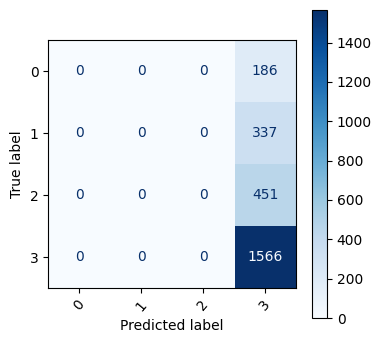

In [47]:
# plot the confusion matrix
rf_cm = confusion_matrix(orignal, t_labels_rf_df)
rf_disp = ConfusionMatrixDisplay(confusion_matrix=rf_cm)

rf_disp.plot(cmap=plt.cm.Blues)
rf_disp.figure_.set_size_inches(4,4)
plt.xticks(rotation=50)
plt.show()



---

